<a href="https://colab.research.google.com/github/ProtossDragoon/paper_implementation_and_testing_tf2/blob/main/utils/Generate_TFRecord.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate TFRecord

## Author

name : Janghoo Lee <br>
github : https://github.com/ProtossDragoon <br>
contact : dlwkdgn1@naver.com <br>
circle : https://github.com/sju-coml <br>
organization : https://web.deering.co/ <br>
published date : June, 2021


## Related Notebook

[Notebooks](https://github.com/ProtossDragoon/paper_implementation_and_testing_tf2/tree/main/notebooks)


# Environment

In [18]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [19]:
import os, sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm.notebook import tqdm as tqdm

## Google Drive / Git

In [20]:
#!rm -r /content/gdrive/
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
USE_GCS = False
HOME_DIR = "/content/gdrive/MyDrive"
WS = os.path.join(HOME_DIR, "ColabWorkspace")
DATA_DIR = os.path.join(HOME_DIR, 'data')
DATA_INDEXFILE_DIR = os.path.join(DATA_DIR, 'index')
DATA_TFRECORD_DIR = os.path.join(DATA_DIR, 'tfrecord')

GIT_REPO_NAME = 'paper_implementation_and_testing_tf2'
GIT_WS = os.path.join(WS, GIT_REPO_NAME)

GIT_BRANCH = 'master'
GIT_USERNAME = None # Add herea
GIT_EMAIL = None
GIT_PASSWORD = None # Add here

In [5]:
!mkdir -p {WS}
%cd {WS}
!git clone https://github.com/ProtossDragoon/{GIT_REPO_NAME}.git
%cd {GIT_WS}
!git config --global user.name {GIT_USERNAME}
!git config --global user.email {GIT_EMAIL}
!git checkout -b {GIT_BRANCH}
!git checkout {GIT_BRANCH}
!git pull origin {GIT_BRANCH}
!git push origin {GIT_BRANCH}
!git branch
!git branch --set-upstream-to origin/{GIT_BRANCH}

/content/gdrive/MyDrive/ColabWorkspace
fatal: destination path 'paper_implementation_and_testing_tf2' already exists and is not an empty directory.
/content/gdrive/MyDrive/ColabWorkspace/paper_implementation_and_testing_tf2
fatal: A branch named 'master' already exists.
Already on 'master'
fatal: Couldn't find remote ref master
fatal: could not read Username for 'https://github.com': No such device or address
  list
  main
* master
  resnet
  tftrt
  unet
error: the requested upstream branch 'origin/master' does not exist
hint: 
hint: If you are planning on basing your work on an upstream
hint: branch that already exists at the remote, you may need to
hint: run "git fetch" to retrieve it.
hint: 
hint: If you are planning to push out a new local branch that
hint: will track its remote counterpart, you may want to use
hint: "git push -u" to set the upstream config as you push.


## [Additional] GCP & TFCloud

Only run for GCP & TF-Cloud. Not for Vanilla google drive user.

### Authenticate GCP User

In [6]:
# !pip install tensorflow_cloud # google colab already has tensorflow cloud
!pip install tensorflow_cloud -q
import tensorflow_cloud as tfc
print(tfc.__version__)

GCP_BUCKET_NAME = 'deer-rudolph'
GCP_PROJECT_NAME = 'deer-deep-learning-project'
GCP_PROJECT_ID = 'linear-freehold-314804'

IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
    if "google.colab" in sys.modules:
        from google.colab import auth
        auth.authenticate_user()
        os.environ["GOOGLE_CLOUD_PROJECT"] = GCP_PROJECT_ID

USE_GCS = True

     |████████████████████████████████| 102kB 7.9MB/s 
     |████████████████████████████████| 153kB 33.7MB/s 
     |████████████████████████████████| 102kB 10.1MB/s 
     |████████████████████████████████| 409kB 31.5MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 19.0MB 1.3MB/s 
     |████████████████████████████████| 17.7MB 421kB/s 
     |████████████████████████████████| 9.6MB 25.9MB/s 
     |████████████████████████████████| 2.3MB 24.8MB/s 
     |████████████████████████████████| 184kB 47.2MB/s 
     |████████████████████████████████| 92kB 9.9MB/s 
     |████████████████████████████████| 153kB 50.3MB/s 
     |████████████████████████████████| 440kB 43.6MB/s 
     |████████████████████████████████| 174kB 60.4MB/s 
     |████████████████████████████████| 174kB 57.0MB/s 
     |████████████████████████████████| 276kB 38.5MB/s 
     |████████████████████████████████| 256kB 38.7MB/s 
ERROR: google-cloud-bigtable 1.7.0 has requirement go

### Global Hyper Parameters

Re-define hyper parameters we defined before.

In [7]:
HOME_DIR = os.path.join('gs://', GCP_BUCKET_NAME)
DATA_DIR = os.path.join(HOME_DIR, 'data')
DATA_INDEXFILE_DIR = os.path.join(DATA_DIR, 'index')
DATA_TFRECORD_DIR = os.path.join(DATA_DIR, 'tfrecord')

# Dataset Library

## CamVid


For this example we will use CamVid dataset. It is a set of:
- **train** images + segmentation masks
- **validation** images + segmentation masks
- **test** images + segmentation masks
- All images have 320 pixels height and 480 pixels width.

<br>

For more inforamtion about dataset visit 
- http://www0.cs.ucl.ac.uk/staff/G.Brostow/papers/Brostow_2009-PRL.pdf
- http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/

### Segmentation task

In [22]:
DATASET_DIR_CAMVID = os.path.join(DATA_DIR, 'camvid')
DATASET_TRAIN_X_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'train')
DATASET_TRAIN_Y_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'trainannot')
DATASET_VAL_X_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'val')
DATASET_VAL_Y_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'valannot')
DATASET_TEST_X_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'test')
DATASET_TEST_Y_DIR_CAMVID = os.path.join(DATASET_DIR_CAMVID, 'testannot')

print('parsed : {}'.format(DATASET_DIR_CAMVID))
if USE_GCS:
    !gsutil ls {DATASET_DIR_CAMVID}
else:
    %cd {DATASET_DIR_CAMVID}
    %ls -al

parsed : /content/gdrive/MyDrive/data/camvid
/content/gdrive/MyDrive/data/camvid
total 81
drwx------ 2 root root  4096 Jun 21 07:14 test/
drwx------ 2 root root  4096 Jun 21 07:14 testannot/
-rw------- 1 root root 19215 Jun 21 07:14 test.txt
drwx------ 2 root root  4096 Jun 21 07:14 train/
drwx------ 2 root root  4096 Jun 21 07:14 trainannot/
-rw------- 1 root root 30053 Jun 21 07:15 train.txt
drwx------ 2 root root  4096 Jun 21 07:14 val/
drwx------ 2 root root  4096 Jun 21 07:14 valannot/
-rw------- 1 root root  7777 Jun 21 07:14 val.txt


## Aihub Pedestrian

For this example we will use Aihub Pedestrian dataset. It is a set of:
- **images and labels** images + segmentation masks
- All images have 1080 pixels height and 1920 pixels width.

<br>

For more inforamtion about dataset visit 
- https://www.aihub.or.kr/aidata/136

<br>

This notebook does not have dataset download link.

### Segmentation task

In [37]:
DATASET_DIR_PEDESTRIAN = os.path.join(DATA_DIR, 'aihubsidewalk')

print('parsed : {}'.format(DATASET_DIR_PEDESTRIAN))
if USE_GCS:
    !gsutil ls {DATASET_DIR_PEDESTRIAN}
else:
    %cd {DATASET_DIR_PEDESTRIAN}
    %ls -al

parsed : /content/gdrive/MyDrive/data/aihubsidewalk
/content/gdrive/MyDrive/data/aihubsidewalk
total 10401
drwx------ 2 root root    4096 Feb 19 02:12 Surface_001/
drwx------ 2 root root    4096 Feb 19 02:12 Surface_002/
drwx------ 2 root root    4096 Feb 19 02:12 Surface_003/
drwx------ 2 root root    4096 Feb 19 02:12 Surface_004/
drwx------ 2 root root    4096 Feb 19 02:12 Surface_005/
drwx------ 2 root root    4096 Feb 19 02:12 Surface_006/
drwx------ 2 root root    4096 Feb 19 02:13 Surface_007/
drwx------ 2 root root    4096 Feb 19 02:13 Surface_008/
drwx------ 2 root root    4096 Feb 19 02:13 Surface_009/
drwx------ 2 root root    4096 Feb 19 02:13 Surface_010/
drwx------ 2 root root    4096 Feb 19 02:13 Surface_011/
drwx------ 2 root root    4096 Feb 19 02:13 Surface_012/
drwx------ 2 root root    4096 Feb 19 02:14 Surface_013/
drwx------ 2 root root    4096 Feb 19 02:14 Surface_014/
drwx------ 2 root root    4096 Feb 19 02:14 Surface_015/
drwx------ 2 root root    4096 Feb 19 

# Convert

## Generate Index file

### Hyper Parameters

In [38]:
DATASETNAME = "aihubpedestrian" #@param ['aihubpedestrian', 'camvid']
TXT_FILE_DIR = os.path.join(DATA_INDEXFILE_DIR, DATASETNAME.upper())

print("Indexfile generation result save  at {}".format(TXT_FILE_DIR))
print("See {}".format(TXT_FILE_DIR))
if USE_GCS:
    !gsutil ls {TXT_FILE_DIR}
else:
    !mkdir -p {TXT_FILE_DIR}
    %cd {TXT_FILE_DIR}
    %ls -al

Indexfile generation result save  at /content/gdrive/MyDrive/data/index/AIHUBPEDESTRIAN
See /content/gdrive/MyDrive/data/index/AIHUBPEDESTRIAN
/content/gdrive/MyDrive/data/index/AIHUBPEDESTRIAN
total 7201
drwx------ 2 root root    4096 Jun 25 07:42 .ipynb_checkpoints/
-rw------- 1 root root  736965 Jun 25 08:23 test
-rw------- 1 root root 5894925 Jun 25 08:23 train
-rw------- 1 root root  736965 Jun 25 08:23 val


### Run

In [39]:
def generate_index_camvid_segmentation(data_dir, 
                                       train_dir, 
                                       trainannot_dir, 
                                       val_dir, 
                                       valannot_dir, 
                                       test_dir, 
                                       testannot_dir, 
                                       save_dir):
    assert tf.io.gfile.isdir(save_dir), '{} is not a directory!'.format(save_dir)
    assert tf.io.gfile.isdir(train_dir), '{} is not a directory!'.format(train_dir)
    assert tf.io.gfile.isdir(trainannot_dir), '{} is not a directory!'.format(trainannot_dir)
    assert tf.io.gfile.isdir(val_dir), '{} is not a directory!'.format(val_dir)
    assert tf.io.gfile.isdir(valannot_dir), '{} is not a directory!'.format(valannot_dir)
    assert tf.io.gfile.isdir(test_dir), '{} is not a directory!'.format(test_dir)
    assert tf.io.gfile.isdir(testannot_dir), '{} is not a directory!'.format(testannot_dir)
    print('generate 3 files :\n{}\n{}\n{}\n'.format(os.path.join(save_dir, 'train.txt'),
                                                    os.path.join(save_dir, 'val.txt'),
                                                    os.path.join(save_dir, 'test.txt'),))
    
    image_train_name_li = tf.io.gfile.listdir(train_dir)
    mask_train_name_li = tf.io.gfile.listdir(trainannot_dir)
    image_val_name_li = tf.io.gfile.listdir(val_dir)
    mask_val_name_li = tf.io.gfile.listdir(valannot_dir)
    image_test_name_li = tf.io.gfile.listdir(test_dir)
    mask_test_name_li = tf.io.gfile.listdir(testannot_dir)
    
    print('Number of image file {}'.format(len(image_train_name_li)+len(image_val_name_li)+len(image_test_name_li)))
    print('Number of mask file {}'.format(len(mask_train_name_li)+len(mask_val_name_li)+len(mask_test_name_li)))

    tf.io.gfile.makedirs(save_dir)
    for f_name, (image_dir, mask_dir), (image_file_names, mask_file_names) in zip(['train', 'val', 'test'], 
                                                                                  [(train_dir, trainannot_dir),
                                                                                   (val_dir, valannot_dir),
                                                                                   (test_dir, testannot_dir)],
                                                                                  [(image_train_name_li, mask_train_name_li),
                                                                                   (image_val_name_li, mask_val_name_li),
                                                                                   (image_test_name_li, mask_test_name_li)]):
        save_full_path = os.path.join(save_dir, f_name)
        print('\nwriting :: \n{}'.format(save_full_path))
        with tf.io.gfile.GFile(save_full_path, mode='w') as f:
            with tqdm(total=len(image_file_names), position=1) as pbar:
                for image_file_name, mask_file_name in zip(image_file_names, mask_file_names):
                    image_line = os.path.join(image_dir, image_file_name)
                    mask_line = os.path.join(mask_dir, mask_file_name)
                    f.write(image_line + ' ' + mask_line+'\n')
                    pbar.update(1)


def generate_index_aihubpedestrian_segmentation(data_dir, save_dir):
    assert tf.io.gfile.isdir(save_dir), '{} is not a directory!'.format(save_dir)
    print('generate 3 files :\n{}\n{}\n{}\n'.format(os.path.join(save_dir, 'train.txt'),
                                                    os.path.join(save_dir, 'val.txt'),
                                                    os.path.join(save_dir, 'test.txt'),))
        
    surface_n_li = tf.io.gfile.listdir(data_dir)
    jpg_li = tf.io.gfile.glob(os.path.join(data_dir, '*/*.jpg'))
    png_li = tf.io.gfile.glob(os.path.join(data_dir, '*/MASK/*.png'))

    print('Number of image file {}'.format(len(jpg_li)))
    print('Number of mask file {}'.format(len(png_li)))

    images_fps = []
    masks_fps = []

    if len(jpg_li) == len(png_li):
        images_fps = jpg_li
        masks_fps = png_li
    else:
        print('Warning : Number of image file {} != number of mask file {}'.format(len(jpg_li), len(png_li)))
        print('Info : Check data manually.')
        with tqdm(total=len(surface_n_li), position=1) as pbar:
            for surface_n in surface_n_li:
                surface_n_dir = os.path.join(data_dir, surface_n)
                if tf.io.gfile.isdir(surface_n_dir):
                    # normal flow
                    f_name_li = tf.io.gfile.listdir(surface_n_dir)
                    for f_name in f_name_li:
                        f_path = os.path.join(surface_n_dir, f_name)
                        if not tf.io.gfile.isdir(f_path): 
                            # it is not mask dir
                            # image file or xml.. etc.
                            f_mask_path = os.path.join(surface_n_dir, 'MASK', f_name.split('.')[0]+'.png')
                            if os.path.exists(f_mask_path):
                                images_fps.append(f_path)
                                masks_fps.append(f_mask_path)
                            else:
                                pass
                        else:
                            pass
                else:
                    pass
                pbar.update(1)

    print('Number of image file {}'.format(len(images_fps)))
    print('Number of mask file {}'.format(len(masks_fps)))
    image_train_fps, image_test_fps, mask_train_fps, mask_test_fps = train_test_split(images_fps, masks_fps, test_size=1/10, shuffle=True)
    image_train_fps, image_val_fps, mask_train_fps, mask_val_fps = train_test_split(image_train_fps, mask_train_fps, test_size=1/9, shuffle=True)
    print('Number of train set : {}'.format(len(image_train_fps)))
    print('Number of val set : {}'.format(len(image_val_fps)))
    print('Number of test set : {}'.format(len(image_test_fps)))
    
    tf.io.gfile.makedirs(save_dir)
    for f_name, (images_fps, masks_fps) in zip(['train', 'val', 'test'], 
                                             [(image_train_fps, mask_train_fps),
                                              (image_val_fps, mask_val_fps),
                                              (image_test_fps, mask_test_fps)]):
        save_full_path = os.path.join(save_dir, f_name)
        print('\nwriting :: \n{}'.format(save_full_path))
        with tf.io.gfile.GFile(save_full_path, mode='w') as f:
            with tqdm(total=len(images_fps), position=1) as pbar:
                for image_line, mask_line in zip(images_fps, masks_fps):
                    f.write(image_line + ' ' + mask_line+'\n')
                    pbar.update(1)

    return images_fps, masks_fps

# implement your custom parser!


if DATASETNAME.lower() == 'camvid':
    generate_index_camvid_segmentation(DATASET_DIR_CAMVID,
                                       DATASET_TRAIN_X_DIR_CAMVID,
                                       DATASET_TRAIN_Y_DIR_CAMVID,
                                       DATASET_VAL_X_DIR_CAMVID,
                                       DATASET_VAL_Y_DIR_CAMVID,
                                       DATASET_TEST_X_DIR_CAMVID,
                                       DATASET_TEST_Y_DIR_CAMVID,
                                       TXT_FILE_DIR)
if DATASETNAME.lower() == 'aihubpedestrian':
    generate_index_aihubpedestrian_segmentation(DATASET_DIR_PEDESTRIAN, TXT_FILE_DIR)

generate 3 files :
/content/gdrive/MyDrive/data/index/AIHUBPEDESTRIAN/train.txt
/content/gdrive/MyDrive/data/index/AIHUBPEDESTRIAN/val.txt
/content/gdrive/MyDrive/data/index/AIHUBPEDESTRIAN/test.txt

Number of image file 46392
Number of mask file 46345
Info : Check data manually.



Number of image file 46345
Number of mask file 46345
Number of train set : 37075
Number of val set : 4635
Number of test set : 4635

writing :: 
/content/gdrive/MyDrive/data/index/AIHUBPEDESTRIAN/train




writing :: 
/content/gdrive/MyDrive/data/index/AIHUBPEDESTRIAN/val




writing :: 
/content/gdrive/MyDrive/data/index/AIHUBPEDESTRIAN/test


### Debug

In [32]:
print('parsed : {}'.format(TXT_FILE_DIR))
if USE_GCS:
    !gsutil ls {TXT_FILE_DIR}
else:
    %cd {TXT_FILE_DIR}
    %ls -al

print('Read line example')
for name in ['train', 'val', 'test']:
    print('file {} example'.format(os.path.join(TXT_FILE_DIR, name)))
    with tf.io.gfile.GFile(os.path.join(TXT_FILE_DIR, name), mode='r') as f:
        for _ in range(5):
            line = f.readline()
            print(line.strip('\n'), '<line end!>')

parsed : /content/gdrive/MyDrive/data/index/CAMVID
/content/gdrive/MyDrive/data/index/CAMVID
total 85
-rw------- 1 root root 29001 Jun 29 05:09 test
-rw------- 1 root root 45467 Jun 29 05:09 train
-rw------- 1 root root 12019 Jun 29 05:09 val
Read line example
file /content/gdrive/MyDrive/data/index/CAMVID/train example
/content/gdrive/MyDrive/data/camvid/train/0001TP_006690.png /content/gdrive/MyDrive/data/camvid/trainannot/0001TP_006690.png <line end!>
/content/gdrive/MyDrive/data/camvid/train/0001TP_006720.png /content/gdrive/MyDrive/data/camvid/trainannot/0001TP_006720.png <line end!>
/content/gdrive/MyDrive/data/camvid/train/0001TP_006750.png /content/gdrive/MyDrive/data/camvid/trainannot/0001TP_006750.png <line end!>
/content/gdrive/MyDrive/data/camvid/train/0001TP_006780.png /content/gdrive/MyDrive/data/camvid/trainannot/0001TP_006780.png <line end!>
/content/gdrive/MyDrive/data/camvid/train/0001TP_006810.png /content/gdrive/MyDrive/data/camvid/trainannot/0001TP_006810.png <line

## Generate TFRecord file

### Hyper Parameters

In [40]:
DATASETNAME = "aihubpedestrian" #@param ['aihubpedestrian', 'camvid']
TFRECORD_FILE_DIR = os.path.join(DATA_TFRECORD_DIR, DATASETNAME.upper())
TFRECORD_FROM_INDEXFILE = True #@param {type:"boolean"}

if not TFRECORD_FROM_INDEXFILE:
    raise NotImplementedError

if TFRECORD_FROM_INDEXFILE:
    INDEX_FILE_DIR_FOR_TFRECORD = TXT_FILE_DIR #@param
    assert tf.io.gfile.exists(INDEX_FILE_DIR_FOR_TFRECORD), '{} not exists!'.format(INDEX_FILE_FULLPATH_FOR_TFRECORD)
    print('Source file : {}'.format(INDEX_FILE_DIR_FOR_TFRECORD))

print("TFRecord Conversion result save at {}".format(TFRECORD_FILE_DIR))
print("See {}".format(TFRECORD_FILE_DIR))
if USE_GCS:
    !gsutil ls {TFRECORD_FILE_DIR}
else:
    !mkdir -p {TFRECORD_FILE_DIR}
    %cd {TFRECORD_FILE_DIR}
    %ls -al

Source file : /content/gdrive/MyDrive/data/index/AIHUBPEDESTRIAN
TFRecord Conversion result save at /content/gdrive/MyDrive/data/tfrecord/AIHUBPEDESTRIAN
See /content/gdrive/MyDrive/data/tfrecord/AIHUBPEDESTRIAN
/content/gdrive/MyDrive/data/tfrecord/AIHUBPEDESTRIAN
total 0


### Run

In [ ]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _imread_tf(image_fp, mask_fp):
    image = tf.io.read_file(image_fp)
    mask = tf.io.read_file(mask_fp)
    image = tf.io.decode_image(image) # 3ch [h, w, 3]
    mask = tf.io.decode_image(mask) # 1ch [h, w, 1] or 3ch [h, w, 3]
    image = tf.image.convert_image_dtype(image, tf.uint8)
    mask = tf.image.convert_image_dtype(mask, tf.uint8)
    return image, mask

def _image_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(
        value=[tf.io.encode_jpeg(value).numpy()]))

def _bytes_feature(value): 
    return tf.train.Feature(bytes_list=tf.train.BytesList(
        value=[value.encode()]))
    
def _create_example(image, mask, image_fp=None, mask_fp=None):    
    feature = {
        "image": _image_feature(image),
        "mask": _image_feature(mask),
    }
    if (image_fp is not None) and (mask_fp is not None):
        feature["image_path"]=_bytes_feature(image_fp)
        featrue["mask_path"]=_bytes_feature(mask_fp)
    return tf.train.Example(features=tf.train.Features(feature=feature))

def convert_to_tfrecord(images_fps, masks_fps, save_full_path):
    print('\nwriting :: \n{}'.format(save_full_path))
    with tqdm(total=len(images_fps)) as pbar:
        with tf.io.TFRecordWriter(save_full_path, options=None) as writer:
            for image_fp, mask_fp in zip(images_fps, masks_fps):
                image, mask = _imread_tf(image_fp, mask_fp)            
                record_bytes = _create_example(image, mask).SerializeToString()
                writer.write(record_bytes)
                pbar.update(1)

def generate_tfrecord_camvid_segmentation(index_dir, save_dir):
    index_file_name_li = tf.io.gfile.listdir(index_dir)
    images_fps = []
    masks_fps = []
    for index_file_name in index_file_name_li:
        reading_file = os.path.join(index_dir, index_file_name)
        print('\nreading :: \n{}'.format(reading_file))
        if tf.io.gfile.isdir(reading_file):
            print('This is a directory! Conversion passed.')
            continue
        with tf.io.gfile.GFile(reading_file, mode='r') as f:
            txt = f.readlines()
            for line in txt:
                line = line.strip('\n')
                image_fp, mask_fp = line.split(' ')
                images_fps.append(image_fp)
                masks_fps.append(mask_fp)
            convert_to_tfrecord(images_fps, masks_fps, os.path.join(save_dir, index_file_name))

def generate_tfrecord_aihubpedestrian_segmentation(index_dir, save_dir):
    index_file_name_li = tf.io.gfile.listdir(index_dir)
    images_fps = []
    masks_fps = []
    for index_file_name in index_file_name_li:
        reading_file = os.path.join(index_dir, index_file_name)
        print('\nreading :: \n{}'.format(reading_file))
        if tf.io.gfile.isdir(reading_file):
            print('This is a directory! Conversion passed.')
            continue
        with tf.io.gfile.GFile(reading_file, mode='r') as f:
            txt = f.readlines()
            for line in txt:
                line = line.strip('\n')
                image_fp, mask_fp = line.split(' ')
                images_fps.append(image_fp)
                masks_fps.append(mask_fp)
            convert_to_tfrecord(images_fps, masks_fps, os.path.join(save_dir, index_file_name))

# implement your custom converter!


if not TFRECORD_FROM_INDEXFILE:
    raise NotImplementedError

if DATASETNAME.lower() == 'camvid':
    generate_tfrecord_camvid_segmentation(INDEX_FILE_DIR_FOR_TFRECORD, TFRECORD_FILE_DIR)
if DATASETNAME.lower() == 'aihubpedestrian':
    generate_tfrecord_aihubpedestrian_segmentation(INDEX_FILE_DIR_FOR_TFRECORD, TFRECORD_FILE_DIR)


reading :: 
/content/gdrive/MyDrive/data/index/AIHUBPEDESTRIAN/.ipynb_checkpoints
This is a directory! Conversion passed.

reading :: 
/content/gdrive/MyDrive/data/index/AIHUBPEDESTRIAN/test

writing :: 
/content/gdrive/MyDrive/data/tfrecord/AIHUBPEDESTRIAN/test


### Debug

parsed : /content/gdrive/MyDrive/data/tfrecord/CAMVID
/content/gdrive/MyDrive/data/tfrecord/CAMVID
total 116766
-rw------- 1 root root 54580331 Jun 29 05:17 test
-rw------- 1 root root 28485805 Jun 29 05:13 train
-rw------- 1 root root 36500918 Jun 29 05:14 val
reading :: /content/gdrive/MyDrive/data/tfrecord/CAMVID/train
there is key named : image
there is key named : mask
reading :: /content/gdrive/MyDrive/data/tfrecord/CAMVID/val
there is key named : image
there is key named : mask
reading :: /content/gdrive/MyDrive/data/tfrecord/CAMVID/test
there is key named : image
there is key named : mask


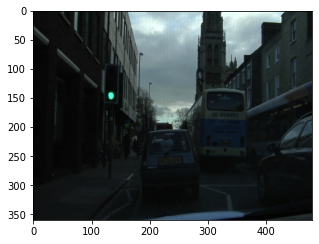

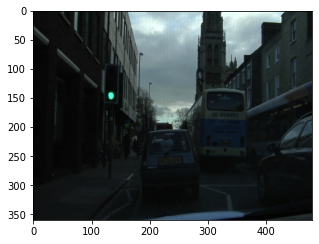

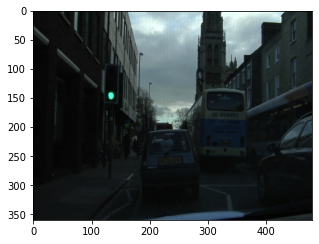

In [35]:
print('parsed : {}'.format(TFRECORD_FILE_DIR))
if USE_GCS:
    !gsutil ls {TFRECORD_FILE_DIR}
else:
    %cd {TFRECORD_FILE_DIR}
    %ls -al

def _parse_tfrecord(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["mask"] = tf.io.decode_jpeg(example["mask"])
    return example

for name in ['train', 'val', 'test']:
    reading_file = os.path.join(TFRECORD_FILE_DIR, name)
    print('reading :: {}'.format(reading_file))
    dataset = tf.data.TFRecordDataset(reading_file).map(_parse_tfrecord)

    for features in dataset.batch(1).take(1):
        for key in features.keys():
            print('there is key named : {}'.format(key))
        
        plt.figure(figsize=(5, 5))
        plt.imshow(features["image"].numpy().squeeze())